- Welcome to Quantitative and High Frequency Trading Training Program
- In this week, we will


- Add rolling maximum and minimum to the data
- Test 5 predictive signals and generate each result
- Compare the resutls to see which signal perform the best
- Compare each day's result to check which days perform the best or worst
- Make some adjustments to the signals and check out the result
- Repeat the process to another data set I give you, each person may have different data sets


- We can repeat some of the process of week 2


- Change the path of helper.r if needed

In [3]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)
## if there is any conflict of duplicate functions between helper and stats
## we use the function of stats

<module 'stats' from '/home/jackie/ResearchArea/Rule-based-forex-trading-system/BabyQuant/python_14th/stats.py'>

 number of cores, set this number according to your computer

In [4]:
# Linux
import multiprocessing
CORE_NUM = multiprocessing.cpu_count()
CORE_NUM

# Windows
# CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
# CORE_NUM

20

- sample product, you can change to your specific product symbol

In [5]:
product_list = ["cu", "zn", "ni", "ag", "au"]

- get all of the dates

In [6]:
import dask
from dask import compute, delayed

- get good night date

- now it's see why we use this kind of data

In [7]:
HEAD_PATH = "/home/jackie/Downloads/dataset"
DATA_PATH = HEAD_PATH + "/"
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
n_days = len(all_dates)


- we randomly choose a day

In [8]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[0])

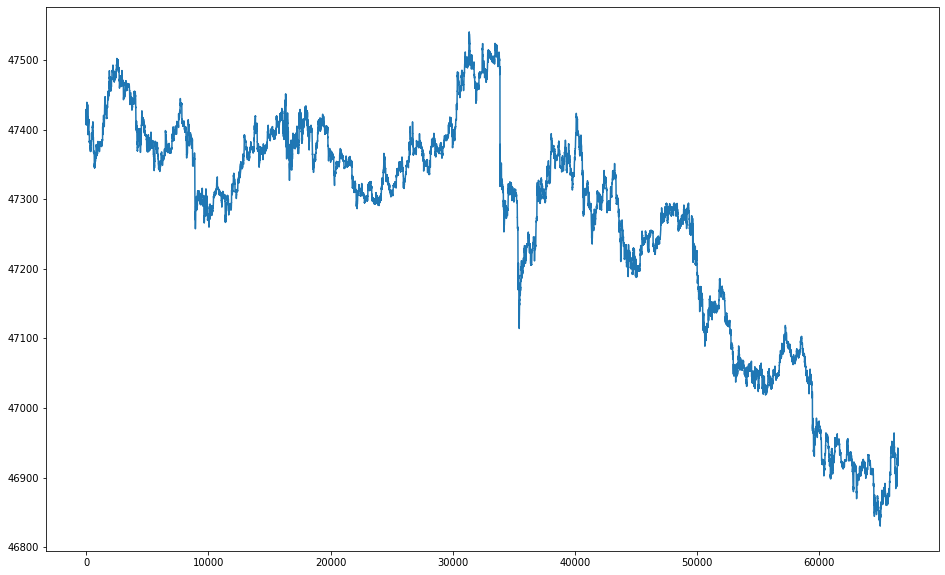

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- plot the maximum price of 2048 ticks
- plot the minimum price of 2048 ticks

In [10]:
period_list = [4096]

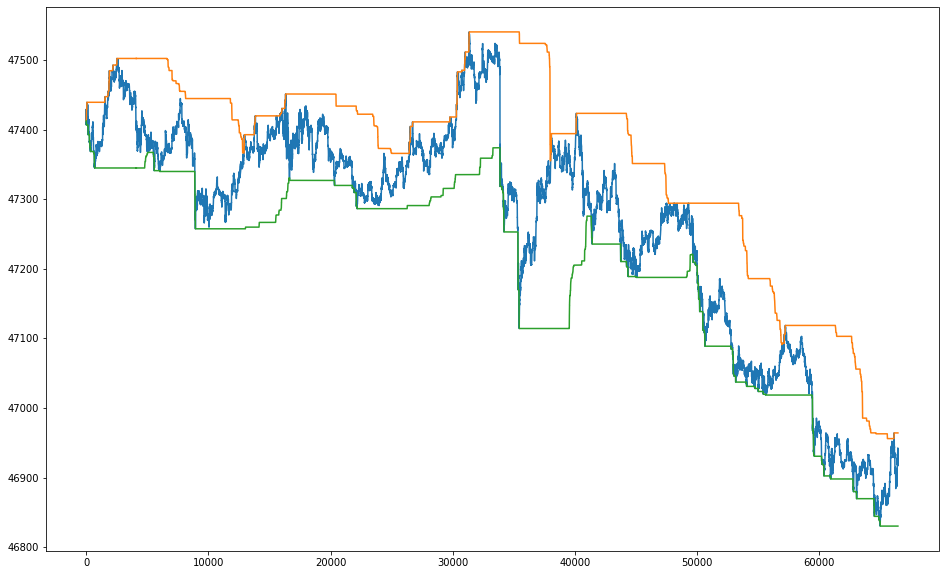

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values)
plt.plot(data["max.4096"].values)
plt.plot(data["min.4096"].values);

## we can see the result meets our expectation
## it may take long time to calculate the min and max of wpr prices
## I give you the estimated time of using 4 cores, so you can deal with other affairs while waiting for result
## but signals using min/max would be sometimes very useful
## the the time to calculating min/max pay off in the end
## In practice, when using c++ to calculating min/max on a rolling basis
## there would be some efficient algorithm, which is faster than comparing all numbers at every tick
## we would talk about it later in our C++ class

- Test 5 predictive signals and generate each result
- now let's see the first signal, which is simply related to price action without trading volume


- set the sample period length

In [12]:
period = 4096

- the first signal

In [14]:
## to calculate the normalized return
## class of factor
## 3 parts: factor_name, params, formula
## 2^[10:13]=(1024,2048,3096)
## the idea is ret/|ret|
## then over a period, we divided by period in numerator and denominator
## (ret/period)/(|ret|/period)
## then we use ewma(ret)/ewma(|ret|) instead of mean return
## because calculate ewma is faster and easier
## but the first period items may not be correct for ewma
## so we use adjust=True
## but since there is avdivision, actually we don't need to use adjust=True
## they would be the same with or withour adjust=True
from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True)).values

In [15]:
## procedure to calculate a signal
## first use a variable to define the class object
x2 = foctor_nr_period()
SAVE_PATH = "/home/jackie/Downloads/signal"
## then create directories to save the result
for product in product_list:
    create_signal_path(x2, product, SAVE_PATH);
    
# e:/intern/tmp pkl/cu/nr.1024
# e:/intern/tmp pkl/cu/nr.2048
# e:/intern/tmp pkl/cu/nr.4096
# e:/intern/tmp pkl/zn/nr.1024
# e:/intern/tmp pkl/zn/nr.2048
# e:/intern/tmp pkl/zn/nr.4096
# e:/intern/tmp pkl/ni/nr.1024
# e:/intern/tmp pkl/ni/nr.2048
# e:/intern/tmp pkl/ni/nr.4096
# e:/intern/tmp pkl/ag/nr.1024
# e:/intern/tmp pkl/ag/nr.2048
# e:/intern/tmp pkl/ag/nr.4096
# e:/intern/tmp pkl/au/nr.1024
# e:/intern/tmp pkl/au/nr.2048
# e:/intern/tmp pkl/au/nr.4096


/home/jackie/Downloads/signal/tmp pkl/cu/nr.4096
/home/jackie/Downloads/signal/tmp pkl/zn/nr.4096
/home/jackie/Downloads/signal/tmp pkl/ni/nr.4096
/home/jackie/Downloads/signal/tmp pkl/ag/nr.4096
/home/jackie/Downloads/signal/tmp pkl/au/nr.4096


In [51]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x2, product=product, HEAD_PATH=SAVE_PATH)
;

CPU times: user 15 s, sys: 656 ms, total: 15.7 s
Wall time: 1min 33s


''

In [16]:
period_list = [4096]
def add_min_max(file, period_list):
    data = load(file)
    for period in period_list:
        data["min."+str(period)] = data["wpr"].rolling(period).min()
        data.loc[:period, ("min."+str(period))] = np.minimum.accumulate(data["wpr"].iloc[:period])
        #data.loc[:period, ("min."+str(period))] = data["wpr"][0]
        data["max."+str(period)] = data["wpr"].rolling(period).max()
        data.loc[:period, ("max."+str(period))] = np.maximum.accumulate(data["wpr"].iloc[:period])
        #data.loc[:period, ("max."+str(period))] = data["wpr"][0]
    save(data, file)

In [17]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, add_min_max, period_list = period_list)
;

# Wall time: 12min 57s

CPU times: user 5.67 s, sys: 674 ms, total: 6.34 s
Wall time: 2min 9s


''

In [20]:
## utilize the bid and ask quantity changes
## but the original quantity may not be stationary, i.e. it would have very large values
## usually from 0 to 200
## but can be up to several tens of thousand
## so we use the change of qty's direction instead
## it has only -1 0 1 so it's stionary, but it's dicrerte
## then we add ewma as fitler to make it more continuous
## we hope the signals are continuous values

from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [22]:
x3 = foctor_dbook_period()
x3
# factor_name:
# dbook.period

# formula:
#     def formula(self, data, period):
#         diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
#         diff_bid_qty[0] = 0
#         diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
#         diff_ask_qty[0] = 0
#         return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


# params:
# $period:[1024 2048 4096]

factor_name:
dbook.period

formula:
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


params:
$period:[4096]

- create directory for dbook signal

In [23]:
SAVE_PATH = "/home/jackie/Downloads/signal"
for product in product_list:
    create_signal_path(x3, product, SAVE_PATH)

# e:/intern/tmp pkl/cu/dbook.4096
# e:/intern/tmp pkl/zn/dbook.4096
# e:/intern/tmp pkl/ni/dbook.4096
# e:/intern/tmp pkl/ag/dbook.4096
# e:/intern/tmp pkl/au/dbook.4096



/home/jackie/Downloads/signal/tmp pkl/cu/dbook.4096
/home/jackie/Downloads/signal/tmp pkl/zn/dbook.4096
/home/jackie/Downloads/signal/tmp pkl/ni/dbook.4096
/home/jackie/Downloads/signal/tmp pkl/ag/dbook.4096
/home/jackie/Downloads/signal/tmp pkl/au/dbook.4096


In [24]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3, product=product, HEAD_PATH=SAVE_PATH)
;

# Wall time: 14min 36s

CPU times: user 15.4 s, sys: 755 ms, total: 16.1 s
Wall time: 1min 28s


''

In [25]:
def moving_average(a, n=3) :
    ret_sum = np.cumsum(a, dtype=float)
    ret = a
    ret[n:] = (ret_sum[n:] - ret_sum[:-n])/n
    return ret


- now we write the all.signal part into a function

In [26]:
SAVE_PATH

'/home/jackie/Downloads/signal'

In [44]:
def get_all_signal(file_list, product, signal_name, period, HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    n_files = len(file_list)
    to_choose = (np.arange(n_files)+1) % 10 == 0
    all_signal = np.array([])
    for file in file_list[to_choose]:
        S = load(SIGNAL_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        data = load(HEAD_PATH+"/"+product+"/"+file)
        signal = S[data["good"]]
        #moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    return all_signal

In [39]:
def get_atr(file, product, period_list, spread, HEAD_PATH):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/data["wpr"]
        os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/atr."+str(period), exist_ok=True)
        save(S, HEAD_PATH+"/tmp pkl/"+product+"/atr."+str(period)+"/" + file[-12:])


In [40]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(12,13)), spread=spread, HEAD_PATH=SAVE_PATH) 

# Wall time: 3min 5s

CPU times: user 2.93 s, sys: 722 ms, total: 3.65 s
Wall time: 1min 7s


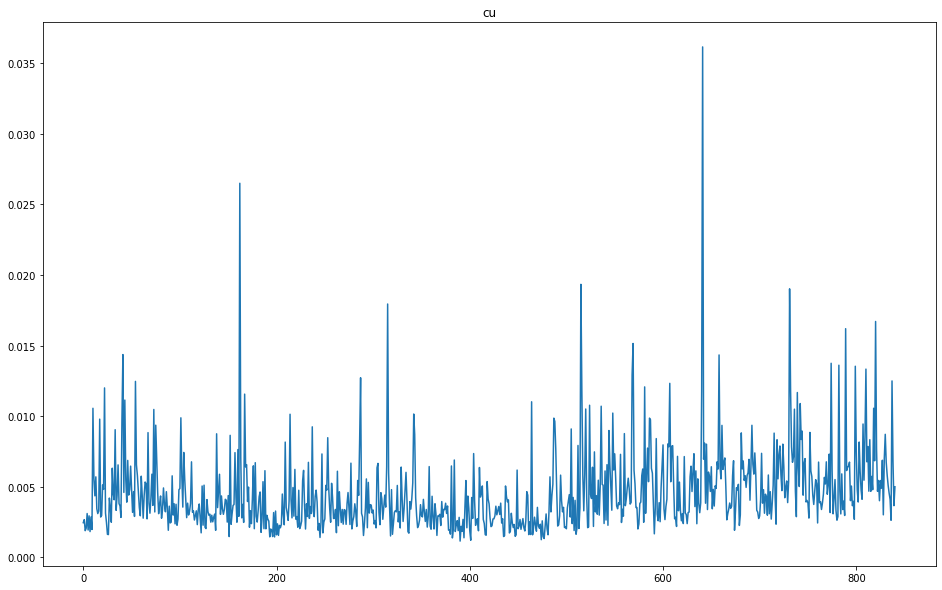

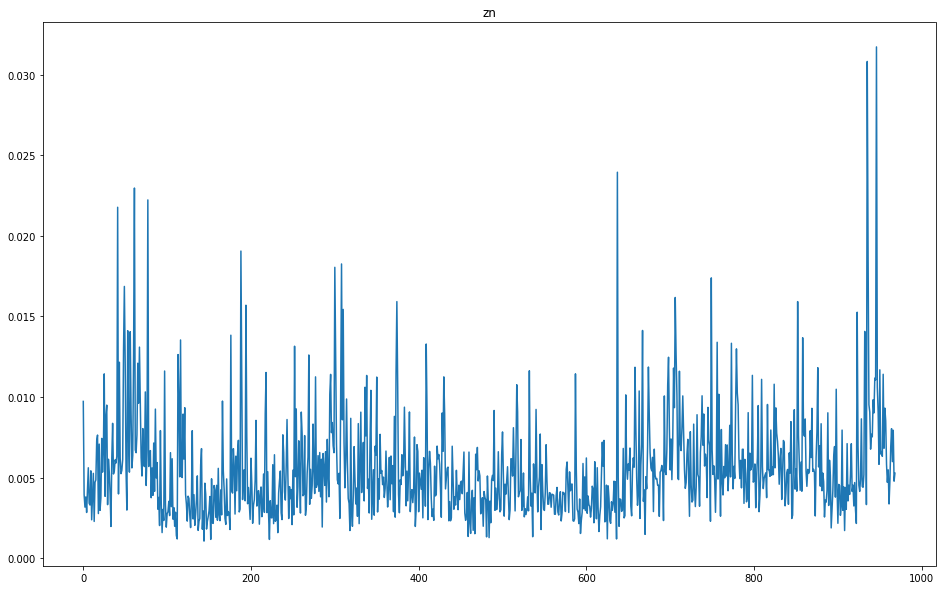

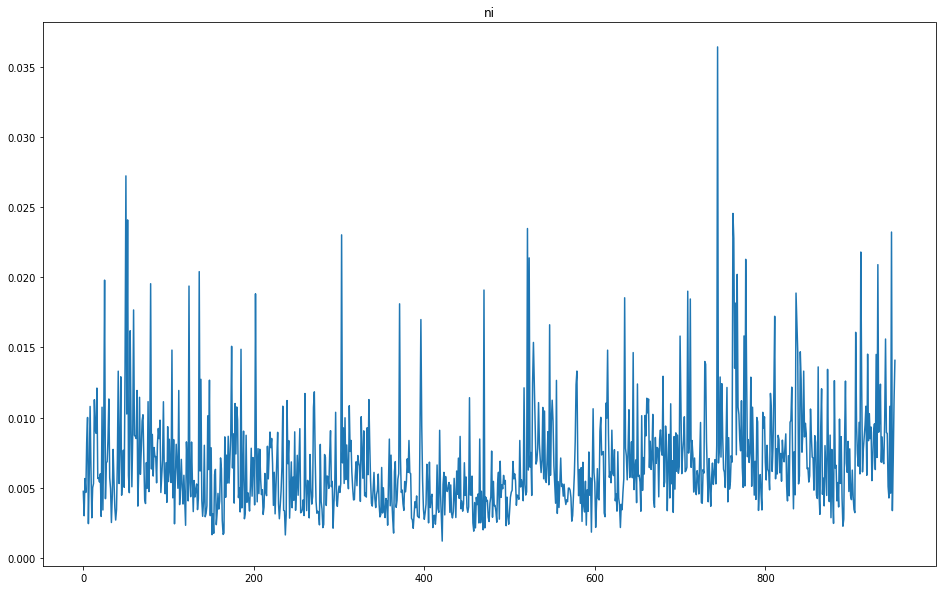

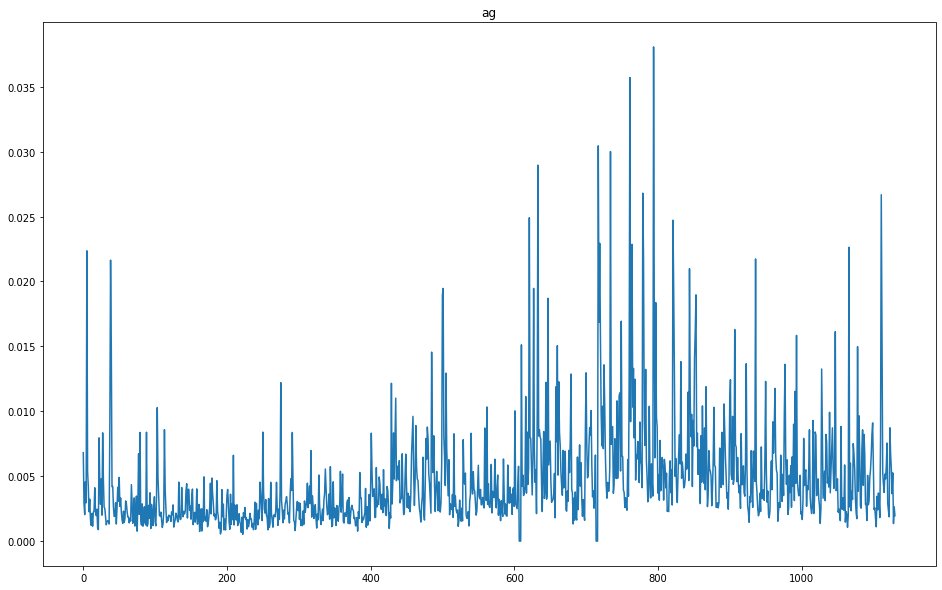

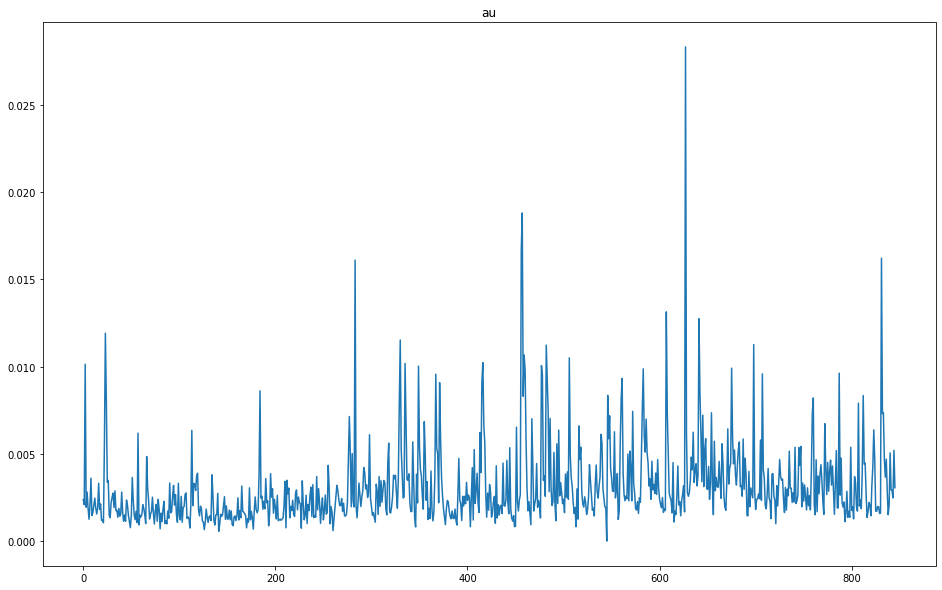

In [45]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "atr."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

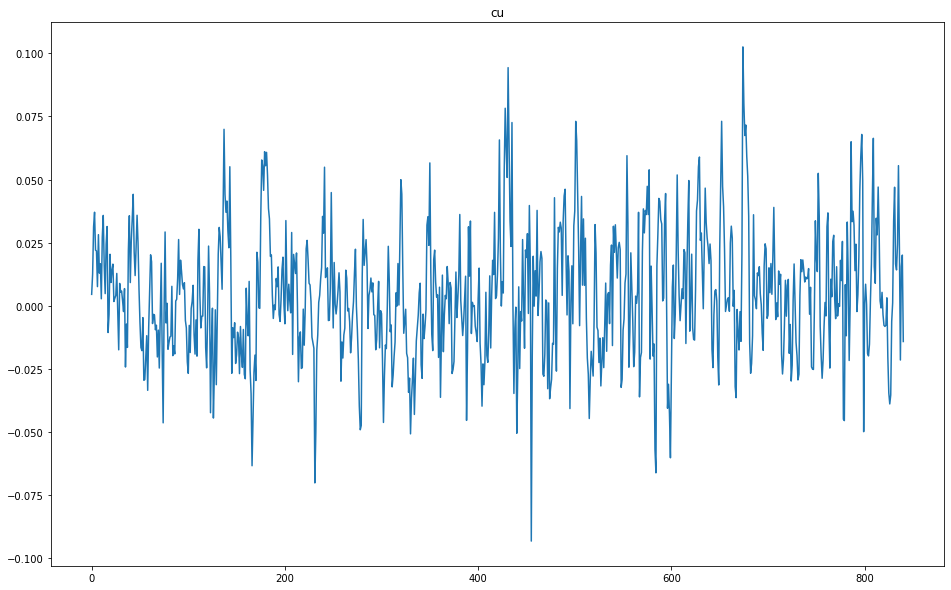

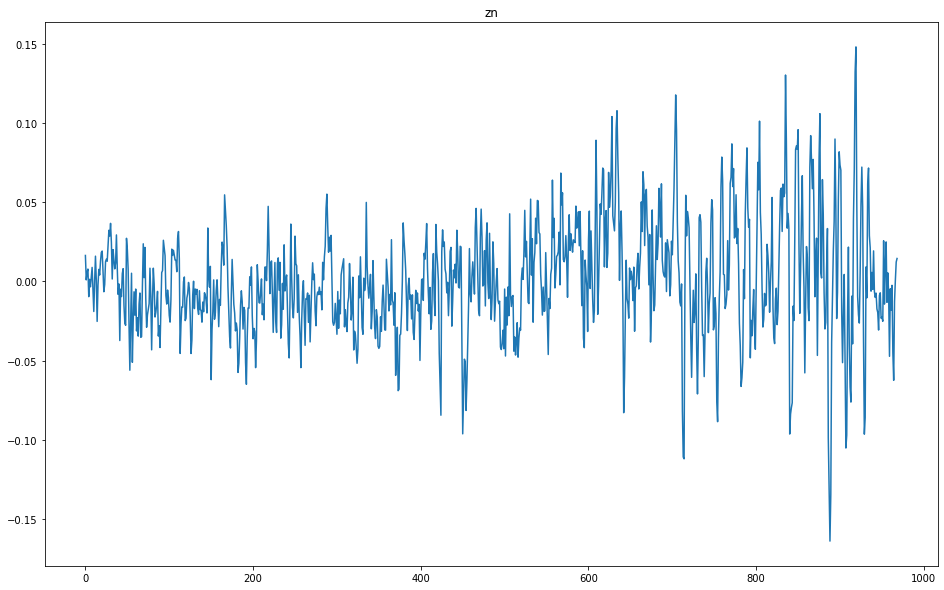

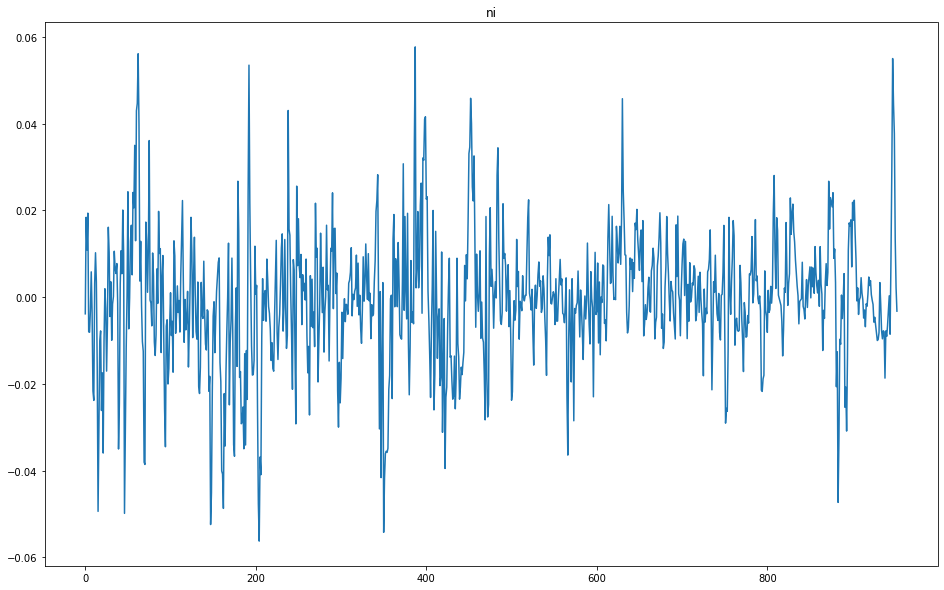

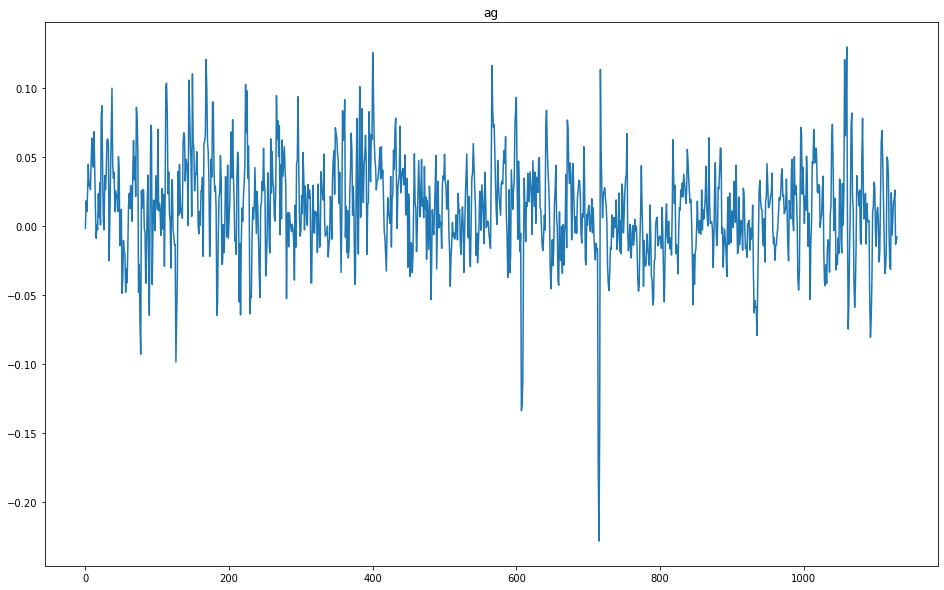

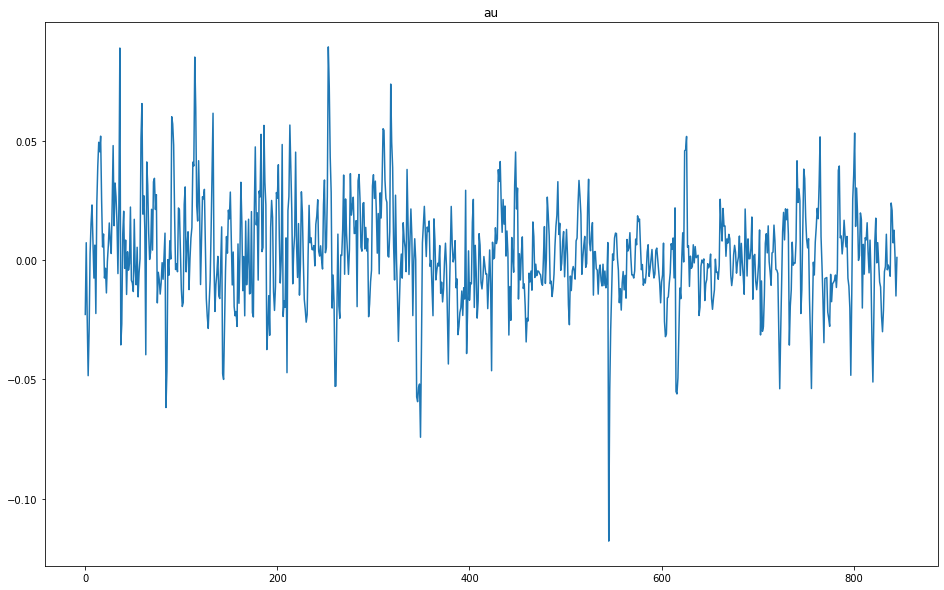

In [46]:
i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "dbook."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- there is no extreme values

In [47]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.04, 0.1, 0.003)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

In [48]:
thre_mat

,open,close
0,0.040,-0.0080
1,0.040,-0.0160
2,0.040,-0.0240
3,0.040,-0.0320
4,0.040,-0.0400
...,...,...
95,0.097,-0.0194
96,0.097,-0.0388
97,0.097,-0.0582
98,0.097,-0.0776


- get the result of training sample

In [49]:
period = 4096
signal_name = "dbook."+str(period)

In [50]:
train_sample = np.array(all_dates)<"201907"

In [51]:
sum(train_sample)
## 511

486

In [52]:
test_sample = np.array(all_dates)>"201907"
sum(test_sample)
## 580

585

In [53]:
%%time
signal_name = "dbook."+str(period)
all_trade_stat = dict([])
SAVE_PATH = "e:/intern"
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

#Wall time:  9min 2s


FileNotFoundError: [Errno 2] No such file or directory: '/home/jackie/Downloads/dataset/pkl tick/cu/20191029.pkl'

Traceback
---------
  File "/home/jackie/anaconda3/envs/rbsys/lib/python3.8/site-packages/dask/local.py", line 220, in execute_task
    result = _execute_task(task, data)
  File "/home/jackie/anaconda3/envs/rbsys/lib/python3.8/site-packages/dask/core.py", line 119, in _execute_task
    return func(*(_execute_task(a, cache) for a in args))
  File "/home/jackie/ResearchArea/Rule-based-forex-trading-system/BabyQuant/python_14th/helper.py", line 222, in get_signal_pnl
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
  File "/home/jackie/ResearchArea/Rule-based-forex-trading-system/BabyQuant/python_14th/helper.py", line 32, in load
    with gzip.open(path, 'rb', compresslevel=1) as file_object:
  File "/home/jackie/anaconda3/envs/rbsys/lib/python3.8/gzip.py", line 58, in open
    binary_file = GzipFile(filename, gz_mode, compresslevel)
  File "/home/jackie/anaconda3/envs/rbsys/lib/python3.8/gzip.py", line 173, in __init__
    fileobj = self.myfileobj = builtins.open(filename, mode or 'rb')


In [ ]:
## save backtest result
save(all_trade_stat, SAVE_PATH+"/"+"metal_trade_stat_"+signal_name+".pkl")

In [ ]:
all_trade_stat = load(SAVE_PATH+"/"+"metal_trade_stat_"+signal_name+".pkl")

In [ ]:
%%time
signal_name = "dbook."+str(period)
all_trade_stat = dict([])
SAVE_PATH = "e:/intern"
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

#Wall time:  10min 14s


In [ ]:
save(all_trade_stat, SAVE_PATH+"/"+"metal_trade_stat_"+signal_name+".pos.pkl")

- get the statistics result of training sample

In [ ]:
all_trade_stat = load(SAVE_PATH+"/"+"metal_trade_stat_"+signal_name+".pos.pkl")
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

- let's see how many good signals there are

In [ ]:
all_trade_stat = load(SAVE_PATH+"/"+"metal_trade_stat_"+signal_name+".pos.pkl")
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates, good_pnl.cumsum());

In [21]:
all_trade_stat = load(SAVE_PATH+"/"+"metal_trade_stat_"+signal_name+".pkl")
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)>1:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates, good_pnl.cumsum());

NameError: name 'signal_name' is not defined

- we can see the result is quite good
- now we can split the samples into training and testing sets

In [ ]:
%%time
train_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread+0.1, tranct_ratio=tranct_ratio, 
                                 HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat
    
## Wall time: 4min 5s

In [ ]:
save(train_trade_stat, SAVE_PATH+"/" + signal_name+"_metal_train_trade_stat.pkl")

In [ ]:
train_trade_stat = load(SAVE_PATH+"/" + signal_name+"_metal_train_trade_stat.pkl")

In [22]:
i = 0
train_trade_stat = load(SAVE_PATH+"/" + signal_name +"_metal_train_trade_stat.pkl")
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    if sum(good_strat)>0:
        good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates[train_sample], good_pnl.cumsum());

NameError: name 'signal_name' is not defined

In [ ]:
%%time
test_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=tranct, max_spread=spread+0.1, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
    test_trade_stat[product] = trade_stat
    
# Wall time: 5min 24s

- at last we plot the selected pnl

- we can check its sharp ratio

In [ ]:
save(test_trade_stat, SAVE_PATH+"/" + signal_name + "_metal_test_trade_stat.pkl")

In [ ]:
test_trade_stat = load(SAVE_PATH+"/" + signal_name + "_metal_test_trade_stat.pkl")

- now let's check how it performs on the test set

In [23]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    if sum(good_strat)>0:
        train_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        trade_stat = test_trade_stat[product]
        test_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
        plt.figure(i, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title(product);
        plt.plot(format_dates[test_sample], test_pnl.cumsum());
    
# cu train sharpe  0.36935966722421376 test sharpe  0.08608281047645933
# zn train sharpe  0.8684528057207155 test sharpe  -0.5871183185811177
# ni train sharpe  0.866892366705809 test sharpe  0.6830009914364394
# ag train sharpe  0.6742335095063331 test sharpe  -0.015102170766010458







NameError: name 'test_sample' is not defined

In [ ]:
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
print("train sharpe ", sharpe(train_portfolio), "test sharpe ", sharpe(test_portfolio))
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])

## ttrain sharpe  1.842606759477945 test sharpe  -0.38614097872815595

- now we see the pnl curve

In [ ]:
print(sharpe(train_portfolio), sharpe(test_portfolio))
## 1.842606759477945 -0.38614097872815595


summary:

- i performs badly in the training set, so it doesn't have any strategies for the test sets, in which it performs well though;

- signal values differ significantly for every product, it makes parameter optimization quite difficult;

- test sets perform better than training set, but it cannot break new high for a long time recently

possible solution:
- choose strategies not based on performance, we can limit the parameters to a small range, and use risk parity to allocate weights to all of them;
- we can use Bayesian Optimization to choose parameters automatically to avoid humen intervention;
- maybe adding i can make the strategies break new high recently

we can try these solutions in the future

- at last we plot the selected pnl

- now we can combine all of these to a function

In [ ]:
atr_filter_list = dict([])
atr_filter_list["cu"] = 0.01
atr_filter_list["zn"] = 0.01
atr_filter_list["ni"] = 0.01
atr_filter_list["ag"] = 0.01
atr_filter_list["au"] = 0.01

In [ ]:
reverse_list = dict([])
reverse_list["cu"] = -1
reverse_list["zn"] = -1
reverse_list["ni"] = -1
reverse_list["ag"] = -1
reverse_list["au"] = -1

In [ ]:
thre_mat_list = dict([])
thre_mat_list["cu"] = thre_mat
thre_mat_list["zn"] = thre_mat
thre_mat_list["ni"] = thre_mat
thre_mat_list["ag"] = thre_mat
thre_mat_list["au"] = thre_mat

In [24]:
## get backtest result of a signal on a product's list
from collections import OrderedDict
def get_list_signal_stat(signal_name, thre_mat_list, product_list, all_dates, atr_filter_list,
                    split_str="2018", min_pnl=2, min_num=20, reverse=1):
    CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
    train_sample = np.array(all_dates)<split_str ## training samples
    test_sample = np.array(all_dates)>split_str ## test samples
    date_str = [n[0:8] for n in all_dates] ## date string
    format_dates = np.array([pd.to_datetime(d) for d in date_str]) ## date in xxxx-xx-xx format
    train_trade_stat = dict([]) ## training result statistics
    print("training")
    for product in product_list:
        print(product)
        spread = product_info[product]["spread"] ## get product's bid/ask spread
        tranct = product_info[product]["tranct"] ## get product's transaction cost
        tranct_ratio = product_info[product]["tranct.ratio"] ## True: tranct cost based on notional; False: fix cost
        thre_mat = thre_mat_list[product]
        atr_filter = atr_filter_list[product]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                      reverse=reverse, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                      HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                      atr_filter=atr_filter)
            train_result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
        trade_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
        train_trade_stat[product] = trade_stat
    print("testing")
    test_trade_stat = dict([])
    for product in product_list:
        print(product)
        spread = product_info[product]["spread"]
        tranct = product_info[product]["tranct"]
        tranct_ratio = product_info[product]["tranct.ratio"]
        thre_mat = thre_mat_list[product]
        atr_filter = atr_filter_list[product]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                     reverse=reverse, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio,
                                      HEAD_PATH = HEAD_PATH, SIGNAL_PATH=SAVE_PATH,
                                      atr_filter=atr_filter)
            result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
        trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
        test_trade_stat[product] = trade_stat
    result=dict([])
    result["train_trade_stat"] = train_trade_stat ## save train stat
    result["test_trade_stat"] = test_trade_stat ## save test stat
    if reverse==-1:
        save(result, HEAD_PATH+"/"+signal_name+".result.pkl") ## reversal strategy
    else:
        save(result, HEAD_PATH+"/"+signal_name+".pos.result.pkl") ## trend strategy

In [25]:
## get train and test result, choose good strategies, plot the portfolio and result of each product

def get_list_signal_result(signal_name, product_list, all_dates, split_str="2018", reverse=1,
                           min_pnl=2, min_num=20):
    if reverse==-1:
        result = load(HEAD_PATH+"/"+signal_name+".result.pkl") ## load reversal strat statistics
    else:
        result = load(HEAD_PATH+"/"+signal_name+".pos.result.pkl") ## load trend strat statistics
    train_trade_stat = result["train_trade_stat"]
    test_trade_stat = result["test_trade_stat"]
    train_sample = np.array(all_dates)<split_str
    test_sample = np.array(all_dates)>split_str
    date_str = [n[0:8] for n in all_dates]
    format_dates = np.array([pd.to_datetime(d) for d in date_str])
    i = 0
    test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
    train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
    for product in product_list:
        spread = product_info[product]["spread"]
        trade_stat = train_trade_stat[product]
        ## two criterion: minimum averge pnl (unit is spread), monimum number of trades
        good_strat = (trade_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (trade_stat["final.result"]["num"]>min_num)
        if sum(good_strat)>0:
            train_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
            train_std = np.std(train_pnl)
            train_pnl = train_pnl/train_std
            trade_stat = test_trade_stat[product]
            test_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
            print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
            test_all_pnl[:,i] = test_pnl
            train_all_pnl[:,i] = train_pnl
            i = i+1
    if i>0:
        train_portfolio = np.array(np.mean(train_all_pnl[:,:i], axis=1))
        test_portfolio = np.array(np.mean(test_all_pnl[:,:i], axis=1))
        all_portfolio = np.append(train_portfolio, test_portfolio)
        plt.figure(1, figsize=(16, 10));
        plt.title("");
        plt.xlabel("date");
        plt.ylabel("pnl");
        plt.title("portfolio");
        plt.plot(format_dates, all_portfolio.cumsum());
        plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
        signal_stat = dict([])
        signal_stat["train.stat"] = train_trade_stat
        signal_stat["test.stat"] = test_trade_stat
        print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))

In [26]:
%%time
get_list_signal_stat("dbook.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                     split_str="201907", min_pnl=2, min_num=20, reverse=-1)

# training
# cu
# zn
# ni
# ag
# au
# testing
# cu
# zn
# ni
# ag
# au
# Wall time: 11min 35s



NameError: name 'thre_mat_list' is not defined

In [27]:
get_list_signal_result("dbook.4096", product_list, all_dates, split_str="201907", reverse=-1,min_pnl=2, min_num=20)

# zn train sharpe  0.9823386665041388 test sharpe  -0.79280693811948
# ni train sharpe  1.3978234249689203 test sharpe  0.7168242571434539
# ag train sharpe  1.0990984890868052 test sharpe  0.09047418142527835
# train sharpe:  2.006146548758745 test sharpe:  -0.26144264613695345





NameError: name 'all_dates' is not defined

- we can test other signals

In [ ]:
## any price is between minimum and maximum
## so if we use (price-min)/(max-min), the result is between [0,1]
## 0 is min, 1 is max
## then we subtract 0.5 from it
## then result is between -0.5 to 0.5
## and finally use ewma to take the average result over a range
from collections import OrderedDict
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values

In [ ]:
def get_range_pos(wpr, min_period, max_period, period):
    return ewma(zero_divide(wpr-min_period, max_period-min_period), period, adjust=True) - 0.5


- let's see waht it looks like

In [ ]:
x4_1 = foctor_range_pos_period()
## we've changed it a little bit from week 2 by adding
## xs.new <- gsub(para.name, value, xs)    
## aa <- with(data,eval(parse(text=xs.new)))
## so be aware that the name of parameter should be complex enough to avoid error

- now we can create path

In [ ]:
for product in product_list:
    create_signal_path(x4_1, product, SAVE_PATH)

# e:/intern/tmp pkl/cu/range.pos.1024
# e:/intern/tmp pkl/cu/range.pos.2048
# e:/intern/tmp pkl/cu/range.pos.4096
# e:/intern/tmp pkl/zn/range.pos.1024
# e:/intern/tmp pkl/zn/range.pos.2048
# e:/intern/tmp pkl/zn/range.pos.4096
# e:/intern/tmp pkl/ni/range.pos.1024
# e:/intern/tmp pkl/ni/range.pos.2048
# e:/intern/tmp pkl/ni/range.pos.4096
# e:/intern/tmp pkl/ag/range.pos.1024
# e:/intern/tmp pkl/ag/range.pos.2048
# e:/intern/tmp pkl/ag/range.pos.4096
# e:/intern/tmp pkl/au/range.pos.1024
# e:/intern/tmp pkl/au/range.pos.2048
# e:/intern/tmp pkl/au/range.pos.4096


- then we calculate the signal

In [ ]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x4_1, product=product, HEAD_PATH=SAVE_PATH)
;

# Wall time: 6min 14s

In [ ]:
signal_name = "range.pos.4096"

- then we can see how the signal looks like

In [28]:
i = 0
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "range.pos."+str(period), period, SIGNAL_PATH=SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

NameError: name 'all_dates' is not defined

- there is no extreme values

In [ ]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.1, 0.3, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [ ]:
%%time
signal_stat = get_list_signal_stat("range.pos.4096", thre_mat_list, product_list, all_dates, atr_filter_list, 
                                   split_str="201907", min_pnl=2, min_num=20, reverse=-1)

# training
# cu
# zn
# ni
# ag
# au
# testing
# cu
# zn
# ni
# ag
# au
# Wall time: 29min 15s


In [ ]:
signal_stat = get_list_signal_result("range.pos.4096", product_list, all_dates, split_str="201907", reverse=-1, 
                                   min_pnl=2, min_num=10)

# cu train sharpe  0.4030607816587913 test sharpe  0.09467190136357097
# zn train sharpe  0.5410637046262803 test sharpe  -0.34748505505835847
# ni train sharpe  0.25307502068685667 test sharpe  0.9133570687018493
# ag train sharpe  0.26975251388336 test sharpe  -0.1364536321702
# train sharpe:  0.6065797189694929 test sharpe:  0.23680630842241657


In [ ]:
## double moving average
## long is perio,d short is round(period/10)
## we can use this idea to consturct many combinations
from collections import OrderedDict
class foctor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

In [ ]:
x99_1 = foctor_ma_diff_period()

In [ ]:
for product in product_list:
    create_signal_path(x99_1, product, SAVE_PATH)

In [ ]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x99_1, product=product, HEAD_PATH=SAVE_PATH)
;
# Wall time: 7min 15s


In [ ]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "ma.dif.10."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [ ]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.005, 0.015, 0.0005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat


In [ ]:
%%time
signal_stat = get_list_signal_stat("ma.dif.10.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str="201907", min_pnl=2, min_num=20, reverse=-1)

# training
# cu
# zn
# ni
# ag
# au
# testing
# cu
# zn
# ni
# ag
# au
# Wall time: 20min 20s



In [ ]:
signal_stat = get_list_signal_result("ma.dif.10.4096", product_list, all_dates, split_str="201907", reverse=-1, 
                                   min_pnl=2, min_num=20)

# cu train sharpe  0.3288054040973939 test sharpe  -0.023362500034886772
# zn train sharpe  0.6595265148214248 test sharpe  -0.24688695401416866
# ni train sharpe  0.11350098677406739 test sharpe  -0.6642363052123694
# ag train sharpe  0.6312635969277888 test sharpe  -1.4401992812164752
# train sharpe:  0.7593677873943758 test sharpe:  -1.4060073810624676







In [ ]:
## similar to double ewma
## but divided by price range
## and short period is round(period/20)
## for exampl.e period/2, period/4, period/8...
## now period = 4096 =2^12, 
from collections import OrderedDict
class foctor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

In [ ]:
x113 = foctor_price_osci_period()
for product in product_list:
    create_signal_path(x113, product, SAVE_PATH)

In [ ]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x113, product=product, HEAD_PATH=SAVE_PATH)
;
# Wall time: 7min 18s

In [ ]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "price.osci."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- before the last signal, let's do some analysis of skewness and kurtosis

In [ ]:
from collections import OrderedDict
import itertools
open_list = np.arange(1, 2, 0.05)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat


In [29]:
%%time

signal_stat = get_list_signal_stat("price.osci.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str="201907", min_pnl=2, min_num=20, reverse=-1)

# training
# cu
# zn
# ni
# ag
# au
# testing
# cu
# zn
# ni
# ag
# au
# Wall time: 7min 12s


NameError: name 'thre_mat_list' is not defined

In [30]:
%%time
signal_stat = get_list_signal_result("price.osci.4096", product_list, all_dates, split_str="201907", reverse=-1, min_pnl=2, min_num=20)

# ni train sharpe  0.2960913569418852 test sharpe  -0.32374012518713774
# train sharpe:  0.2960913569418827 test sharpe:  -0.3237401251871404
# Wall time: 289 ms



NameError: name 'all_dates' is not defined

In [31]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "nr."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

NameError: name 'all_dates' is not defined

In [ ]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.07, 0.15, 0.004)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [ ]:
%%time
signal_stat = get_list_signal_stat("nr.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str="201907", min_pnl=2, min_num=20, reverse=1)

# training
# cu
# zn
# ni
# ag
# au
# testing
# cu
# zn
# ni
# ag
# au
# Wall time: 6min


In [32]:
%%time
signal_stat = get_list_signal_result("nr.4096", product_list, all_dates, split_str="201907", reverse=1, min_pnl=2, min_num=20)

# cu train sharpe  0.23120383433407538 test sharpe  -0.2243182069386369
# zn train sharpe  0.8107592281293946 test sharpe  -0.10879406598185952
# ni train sharpe  0.38124800165721334 test sharpe  -1.967702460773413
# ag train sharpe  0.6687548806900961 test sharpe  0.04177943242197776
# train sharpe:  1.0072513252465154 test sharpe:  -0.6223353840539168
# Wall time: 324 ms


NameError: name 'all_dates' is not defined

In [33]:
from scipy.stats import kurtosis
from scipy.stats import skew
def get_signal_moment(signal, all_dates, product_list, period):
    for product in product_list:
        all_signal = get_all_signal(np.array(all_dates), product, signal+"."+str(period), period, SIGNAL_PATH=SAVE_PATH)
        all_signal = all_signal[np.isnan(all_signal)==False]
        print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))

In [34]:
%%time
get_signal_moment("dbook", all_dates, product_list, 4096)

# cu kurtosis= 3.610218747915994  skew= 0.2689442596815311
# zn kurtosis= 4.675467185352762  skew= 0.16138052304514477
# ni kurtosis= 4.7969546337336695  skew= -0.09138972573451697
# ag kurtosis= 6.303918635375034  skew= -0.40612549269065656
# au kurtosis= 5.2678636150937805  skew= 0.05850436503576908
# Wall time: 1min 43s


NameError: name 'all_dates' is not defined

In [35]:
%%time
get_signal_moment("range.pos", all_dates, product_list, 4096)

# cu kurtosis= 2.3097077374123565  skew= -0.06810984021266873
# zn kurtosis= 2.4204173810471112  skew= -0.07542041534714185
# ni kurtosis= 2.3901937891133573  skew= 0.0694582085886265
# ag kurtosis= 3.5191329626368715  skew= -0.4456559170519343
# au kurtosis= 2.554261262293925  skew= -0.035973972252093554
# Wall time: 1min 43s



NameError: name 'all_dates' is not defined

In [36]:
%%time
get_signal_moment("ma.dif.10", all_dates, product_list, 4096)

# cu kurtosis= 5.709051135668319  skew= -0.5563827386426722
# zn kurtosis= 8.681420256963621  skew= -0.03785028433949452
# ni kurtosis= 5.753683938905683  skew= -0.31537277305734945
# ag kurtosis= 66.08615333870742  skew= -4.56860693209022
# au kurtosis= 16.72132396920803  skew= -1.3369543123235392
# Wall time: 1min 43s




NameError: name 'all_dates' is not defined

In [37]:
%%time
get_signal_moment("price.osci", all_dates, product_list, 4096)

# cu kurtosis= 2.5923993455913226  skew= 0.15898371710677306
# zn kurtosis= 2.9189573205281443  skew= -0.08224446724758909
# ni kurtosis= 3.4395287584578442  skew= 0.16769981005479692
# ag kurtosis= 3.6954814877775752  skew= 0.11647635099473617
# au kurtosis= 3.902873498574268  skew= 0.31509303336133054
# Wall time: 1min 43s




NameError: name 'all_dates' is not defined

In [38]:
%%time
get_signal_moment("nr", all_dates, product_list, 4096)

# cu kurtosis= 3.65258019759632  skew= -0.08680943390233883
# zn kurtosis= 4.5498520266722835  skew= 0.10082917081697598
# ni kurtosis= 5.120825276842938  skew= -0.34480615640353646
# ag kurtosis= 181.70807474304928  skew= -11.144190492574554
# au kurtosis= 6.369564447350382  skew= 0.6341242473793738
# Wall time: 1min 43s






NameError: name 'all_dates' is not defined

In [39]:
class foctor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                   adjust=True).values
    

In [40]:
x11 = foctor_kdj_k_period()
for product in product_list:
    create_signal_path(x11, product, SAVE_PATH)

e:/intern/tmp pkl/cu/kdj.k.4096
e:/intern/tmp pkl/zn/kdj.k.4096
e:/intern/tmp pkl/ni/kdj.k.4096
e:/intern/tmp pkl/ag/kdj.k.4096
e:/intern/tmp pkl/au/kdj.k.4096


In [41]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x11, product=product, HEAD_PATH=SAVE_PATH)
;

#Wall time: 4min 10s


FileNotFoundError: [Errno 2] No such file or directory: 'd:/intern/pkl tick/cu'

In [42]:
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.k."+str(period), period,HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))

# cu kurtosis= 1.7415747757119655  skew= -0.03606462028636038
# zn kurtosis= 1.8062213438029096  skew= -0.06649905745128377
# ni kurtosis= 1.9357873901228462  skew= -0.022300893260894773
# ag kurtosis= 1.8139128831708191  skew= -0.06862381233085507
# au kurtosis= 1.761613275339543  skew= -0.04852270090353397



NameError: name 'all_dates' is not defined

- we know that standard normal distribution is 3, so 3.29 is a little bit higher but still close to normal distribution
- as we see above, range.pos.signal and dbook.signal are good signals, they have kurtosis of slightly above 3
- open.int.ret.signal and nr.signal are not good signals, and they have kurtosis above 8
- nr.vanish.signal is better than nr.signal, and it has kurtosis much lower
- so when we want to improve our signals, we can focus on how to decrease the kurtosis


- kurtosis is used to measure fatness and thiness of the shape of the density distribution
- financial has fat tails, which may lead to large kurtosis value
- so we can use vanish techniques to reduce it 

In [ ]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [ ]:
%%time
signal_stat = get_list_signal_stat("kdj.k.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str = "201907", min_pnl=2, min_num=20,reverse=1)

# training
# cu
# zn
# ni
# ag
# au
# testing
# cu
# zn
# ni
# ag
# au
# Wall time: 37min 57s



In [ ]:
%%time
signal_stat = get_list_signal_result("kdj.k.4096", product_list, all_dates, split_str="201907", reverse=1, min_pnl=2, min_num=20)

# zn train sharpe  0.6463954719824776 test sharpe  -0.16381034101449377
# ni train sharpe  0.9479549990286305 test sharpe  -0.4678031967924608
# train sharpe:  1.0477960780822433 test sharpe:  -0.4364315998681509
# Wall time: 315 ms





In [ ]:
class foctor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                        adjust=True), round(period/5), adjust=True).values
    


In [ ]:
x12 = foctor_kdj_j_period()
for product in product_list:
    create_signal_path(x12, product, SAVE_PATH)

In [ ]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x12, product=product, HEAD_PATH=SAVE_PATH)
;
# Wall time: 4min 8s

In [ ]:
%%time
i = 0
period = 4096
for product in product_list:
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.j."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1;
    plt.figure(i, figsize=(16, 10));
    plt.title(product);
    plt.plot(all_signal);
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal));
    
# cu kurtosis= 1.9256095260240362  skew= -0.03954952399222656
# zn kurtosis= 1.9848024017548094  skew= -0.053363408308200036
# ni kurtosis= 2.017168015870702  skew= -0.001629462484980246
# ag kurtosis= 2.2208892193603824  skew= -0.12235847382905254
# au kurtosis= 1.9594622581793746  skew= 0.0011849359885663063
# Wall time: 1min 43s





In [ ]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.6, 0.8, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [ ]:
%%time
signal_stat = get_list_signal_stat("kdj.j.4096", thre_mat_list, product_list, all_dates, atr_filter_list,
                                   split_str = "201907", min_pnl=2, min_num=20,reverse=1)

# training
# cu
# zn
# ni
# ag
# au
# testing
# cu
# zn
# ni
# ag
# au
# Wall time: 22min 49s


In [ ]:
%%time
signal_stat = get_list_signal_result("kdj.j.4096", product_list, all_dates, split_str="201907", reverse=1, min_pnl=2, min_num=20)

# cu train sharpe  0.3257434771261841 test sharpe  -0.3983470761806166
# zn train sharpe  0.9641417500604003 test sharpe  -2.2068464759711737
# ni train sharpe  0.6611694063281071 test sharpe  -0.6603477118113737
# train sharpe:  1.0216015184825564 test sharpe:  -1.5300525757433123
# Wall time: 298 ms


